In [1]:
import os # File system operations
import re # Regular expressions
import pandas as pd # Tabular data
import numpy as np # Numerical data
pd.set_option('display.max_colwidth', None) # Show full file paths

# Don't use all of the GPU RAM
import tensorflow as tf
gpus = tf.config.experimental.list_physical_devices('GPU')
for gpu in gpus:
  tf.config.experimental.set_memory_growth(gpu, True)
from tensorflow import keras # ML

from sklearn.metrics import confusion_matrix, classification_report, accuracy_score

from pathlib import Path
from glob import glob
import matplotlib.pyplot as plt # Plotting
import seaborn as sns # Plotting
sns.set()
from tqdm.auto import tqdm # Progress bars

BASE_DIR = Path("EmbryoLabeling/Labelers/One")
folders = os.listdir(BASE_DIR)
folders = [f for f in folders if not re.match(r"M\d", f)]
files = []
for folder in folders:
    files_in_folder = pd.DataFrame(glob(f"{BASE_DIR}/{folder}/**/*.jpg", recursive=True), columns=["filename"])
    files_in_folder["class"] = folder
    files.append(files_in_folder)
df = pd.concat(files)
df["class"].value_counts()

2022-05-10 03:59:00.313642: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-05-10 03:59:00.356228: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-05-10 03:59:00.356419: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero


bad                  10334
Empty                 5797
Morula                  82
Compacting 8 cell       38
2 Cell                  36
Blastocyst              35
4 Cell                  31
2pn                     19
Early blast              8
Cavitating morula        7
7 Cell                   6
8 Cell                   5
Syngamy                  5
5 Cell                   4
3 Cell                   4
10 plus Cell             4
9 Cell                   3
6 Cell                   1
Name: class, dtype: int64

<AxesSubplot:>

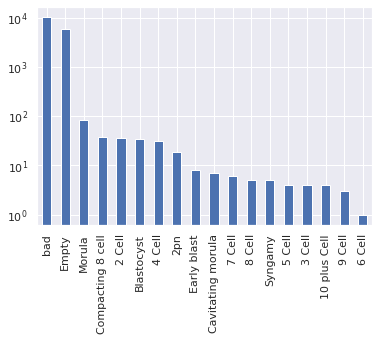

In [2]:
df["class"].value_counts().plot.bar(logy=True)

In [3]:
pd.set_option('display.max_rows', 365)
M776_S0087_W2 = df[df.filename.str.contains("M776_S0087_W2")].copy()
M776_S0087_W2["time_since_fert"] = M776_S0087_W2.filename.apply(lambda s: s.replace(".jpg", "").split("_")[-1]).astype(int)
M776_S0087_W2 = M776_S0087_W2.sort_values(by="time_since_fert")
M776_S0087_W2 = M776_S0087_W2.groupby("class").head(1)
print(M776_S0087_W2[["class", "time_since_fert"]])

                  class  time_since_fert
12                  2pn             1061
3               Syngamy             1464
17               2 Cell             1574
0                3 Cell             2315
1                4 Cell             2395
1                5 Cell             3045
0                6 Cell             3125
1                7 Cell             3145
2                8 Cell             3265
1     Compacting 8 cell             3375
2                9 Cell             4146
3          10 plus Cell             4206
70               Morula             4286
6     Cavitating morula             5940
1           Early blast             6090
10           Blastocyst             6261
4850              Empty             7036


In [4]:
classes = list(M776_S0087_W2["class"])
classes

['2pn',
 'Syngamy',
 '2 Cell',
 '3 Cell',
 '4 Cell',
 '5 Cell',
 '6 Cell',
 '7 Cell',
 '8 Cell',
 'Compacting 8 cell',
 '9 Cell',
 '10 plus Cell',
 'Morula',
 'Cavitating morula',
 'Early blast',
 'Blastocyst',
 'Empty']

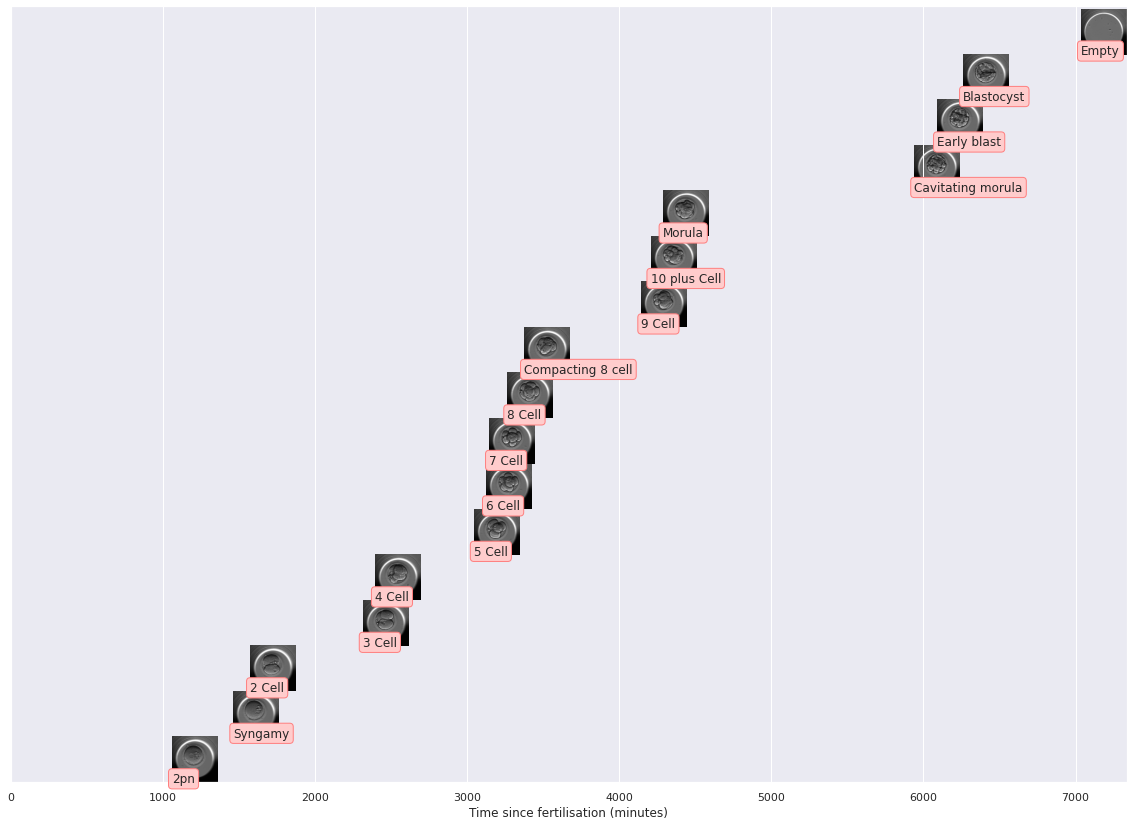

In [5]:
plt.figure(figsize=(20, 20))
for i, row in M776_S0087_W2.iterrows():
    image = keras.utils.load_img(row.filename, target_size=(299,299))
    c_index = classes.index(row["class"]) * 299
    time_since_fert = row.time_since_fert
    plt.imshow(image, extent=[time_since_fert, time_since_fert+299, c_index, c_index+299])
    plt.text(time_since_fert, c_index, row["class"], bbox=dict(boxstyle="round", ec=(1., 0.5, 0.5), fc=(1., 0.8, 0.8)))
plt.yticks([])
plt.xlabel("Time since fertilisation (minutes)")
plt.xlim(0, M776_S0087_W2.time_since_fert.max() + 300)
plt.ylim(0, len(classes) * 300)
plt.show()

In [6]:
class_counts = df["class"].value_counts()
mask = ~df["class"].isin(class_counts[class_counts > 10].index)
#df["class"][mask] = "Other"

In [7]:
#df["class"][~df["class"].isin(["Empty", "Morula"])] = "Other"
train_rows = []
validation_rows = []
for c in df["class"].unique():
    df_for_class = df[df["class"] == c].copy()
    if len(df_for_class) > 20:
        validation_sample = df_for_class.sample(10)
        validation_rows.append(validation_sample)
        train_sample = df_for_class.drop(validation_sample.index)
        # Accounting for training class imbalance
        train_sample = train_sample.sample(min(len(train_sample), 200))
        train_rows.append(train_sample)
train_df = pd.concat(train_rows)
validation_df = pd.concat(validation_rows)
display(df)
display(train_df["class"].value_counts())
validation_df = validation_df.sample(frac=1)
display(validation_df["class"].value_counts())

,filename,class
0,EmbryoLabeling/Labelers/One/bad/M3169_S00479_W2_F0_5345.jpg,bad
1,EmbryoLabeling/Labelers/One/bad/M0831_S00479_W5_F0_3273.jpg,bad
2,EmbryoLabeling/Labelers/One/bad/M0831_S00479_W5_F0_3493.jpg,bad
3,EmbryoLabeling/Labelers/One/bad/M3169_S00087_W1_F0_687.jpg,bad
4,EmbryoLabeling/Labelers/One/bad/M3169_S00087_W1_F0_657.jpg,bad
...,...,...
31,EmbryoLabeling/Labelers/One/2 Cell/M776_S0087_W2_F0_2115.jpg,2 Cell
32,EmbryoLabeling/Labelers/One/2 Cell/M776_S0087_W2_F0_2175.jpg,2 Cell
33,EmbryoLabeling/Labelers/One/2 Cell/M776_S0087_W2_F0_1995.jpg,2 Cell
34,EmbryoLabeling/Labelers/One/2 Cell/M776_S0087_W2_F0_2055.jpg,2 Cell


bad                  200
Empty                200
Morula                72
Compacting 8 cell     28
2 Cell                26
Blastocyst            25
4 Cell                21
Name: class, dtype: int64

Empty                10
bad                  10
Morula               10
Blastocyst           10
2 Cell               10
4 Cell               10
Compacting 8 cell    10
Name: class, dtype: int64

In [8]:
datagen = keras.preprocessing.image.ImageDataGenerator(rescale=1./255)
training = datagen.flow_from_dataframe(train_df, target_size=(299, 299), batch_size=24, shuffle=True)
# Don't shuffle validation, otherwise confusion_matrix won't work due to mismatch
validation = datagen.flow_from_dataframe(validation_df, target_size=(299, 299), batch_size=24, shuffle=False)

Found 572 validated image filenames belonging to 7 classes.
Found 70 validated image filenames belonging to 7 classes.


In [9]:
assert training.class_indices == validation.class_indices

In [10]:
list(training.class_indices.keys())

['2 Cell',
 '4 Cell',
 'Blastocyst',
 'Compacting 8 cell',
 'Empty',
 'Morula',
 'bad']

In [11]:
code2class = {v:k for k, v in training.class_indices.items()}
code2class

{0: '2 Cell',
 1: '4 Cell',
 2: 'Blastocyst',
 3: 'Compacting 8 cell',
 4: 'Empty',
 5: 'Morula',
 6: 'bad'}

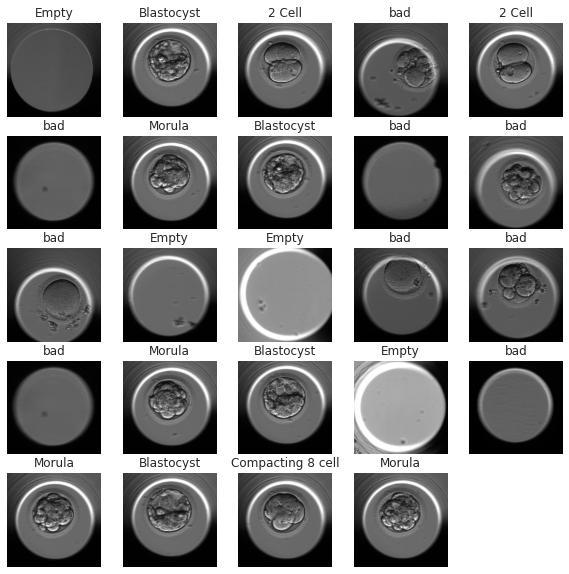

In [12]:
plt.figure(figsize=(10, 10))
images, labels = next(training)
for i in range(24):
    ax = plt.subplot(5, 5, i + 1)
    plt.imshow(images[i])
    plt.title(code2class[labels[i].argmax()])
    plt.axis("off")

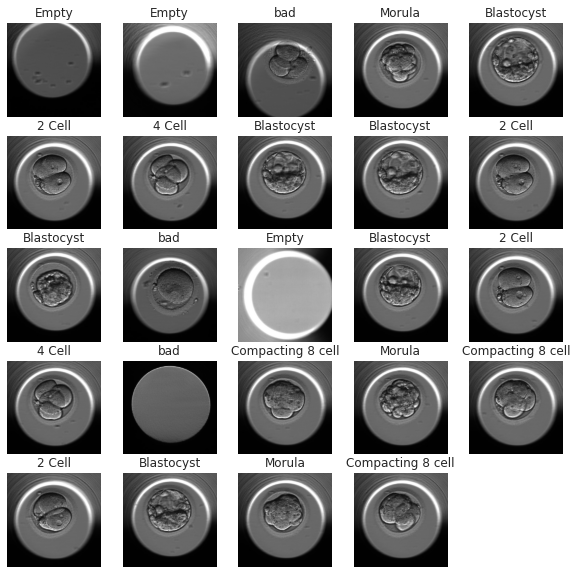

In [13]:
plt.figure(figsize=(10, 10))
images, labels = next(validation)
for i in range(min(24, len(labels))):
    ax = plt.subplot(5, 5, i + 1)
    plt.imshow(images[i])
    plt.title(code2class[labels[i].argmax()])
    plt.axis("off")

In [14]:
base_model = keras.applications.Xception(
    weights='imagenet',  # Load weights pre-trained on ImageNet.
    input_shape=(299, 299, 3),
    include_top=False)  # Do not include the ImageNet classifier at the top.

# Freeze the base_model
base_model.trainable = False

# Create new model on top
inputs = keras.Input(shape=(299, 299, 3))

# Pre-trained Xception weights requires that input be scaled
# from (0, 255) to a range of (-1., +1.), the rescaling layer
# outputs: `(inputs * scale) + offset`
scale_layer = keras.layers.Rescaling(scale=2, offset=-1)
x = scale_layer(inputs)

# The base model contains batchnorm layers. We want to keep them in inference mode
# when we unfreeze the base model for fine-tuning, so we make sure that the
# base_model is running in inference mode here.
x = base_model(x, training=False)
x = keras.layers.GlobalAveragePooling2D()(x)
#x = keras.layers.Dropout(0.2)(x)  # Regularize with dropout
outputs = keras.layers.Dense(len(code2class), activation='softmax')(x)
model = keras.Model(inputs, outputs)

model.summary()

2022-05-10 03:59:05.093864: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-05-10 03:59:05.094933: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-05-10 03:59:05.095152: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-05-10 03:59:05.095286: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA 

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 299, 299, 3)]     0         
                                                                 
 rescaling (Rescaling)       (None, 299, 299, 3)       0         
                                                                 
 xception (Functional)       (None, 10, 10, 2048)      20861480  
                                                                 
 global_average_pooling2d (G  (None, 2048)             0         
 lobalAveragePooling2D)                                          
                                                                 
 dense (Dense)               (None, 7)                 14343     
                                                                 
Total params: 20,875,823
Trainable params: 14,343
Non-trainable params: 20,861,480
____________________________________________

In [15]:
%%time
training.reset()
validation.reset()
model.compile(
    optimizer=keras.optimizers.Adam(),
    loss=keras.losses.CategoricalCrossentropy(),
    metrics=[keras.metrics.CategoricalAccuracy()],
)

history = model.fit(training, epochs=60, validation_data=validation)

Epoch 1/60


2022-05-10 03:59:10.100665: I tensorflow/stream_executor/cuda/cuda_dnn.cc:368] Loaded cuDNN version 8302
2022-05-10 03:59:10.793759: I tensorflow/core/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory


24/24 [==============================] - 7s 149ms/step - loss: 1.2728 - categorical_accuracy: 0.5594 - val_loss: 1.5103 - val_categorical_accuracy: 0.3714
Epoch 2/60
24/24 [==============================] - 2s 93ms/step - loss: 0.7133 - categorical_accuracy: 0.8339 - val_loss: 0.9682 - val_categorical_accuracy: 0.7571
Epoch 3/60
24/24 [==============================] - 2s 93ms/step - loss: 0.4833 - categorical_accuracy: 0.9283 - val_loss: 0.6973 - val_categorical_accuracy: 0.8714
Epoch 4/60
24/24 [==============================] - 2s 90ms/step - loss: 0.3559 - categorical_accuracy: 0.9441 - val_loss: 0.4979 - val_categorical_accuracy: 0.9571
Epoch 5/60
24/24 [==============================] - 2s 99ms/step - loss: 0.2878 - categorical_accuracy: 0.9493 - val_loss: 0.4234 - val_categorical_accuracy: 0.9429
Epoch 6/60
24/24 [==============================] - 2s 90ms/step - loss: 0.2379 - categorical_accuracy: 0.9615 - val_loss: 0.3733 - val_categorical_accuracy: 0.9286
Epoch 7/60
24/24 [==

24/24 [==============================] - 2s 87ms/step - loss: 0.0179 - categorical_accuracy: 1.0000 - val_loss: 0.0488 - val_categorical_accuracy: 0.9857
Epoch 51/60
24/24 [==============================] - 2s 86ms/step - loss: 0.0175 - categorical_accuracy: 1.0000 - val_loss: 0.0508 - val_categorical_accuracy: 0.9857
Epoch 52/60
24/24 [==============================] - 2s 86ms/step - loss: 0.0170 - categorical_accuracy: 1.0000 - val_loss: 0.0460 - val_categorical_accuracy: 0.9857
Epoch 53/60
24/24 [==============================] - 2s 87ms/step - loss: 0.0167 - categorical_accuracy: 1.0000 - val_loss: 0.0462 - val_categorical_accuracy: 0.9857
Epoch 54/60
24/24 [==============================] - 2s 89ms/step - loss: 0.0161 - categorical_accuracy: 1.0000 - val_loss: 0.0488 - val_categorical_accuracy: 0.9857
Epoch 55/60
24/24 [==============================] - 2s 94ms/step - loss: 0.0155 - categorical_accuracy: 1.0000 - val_loss: 0.0438 - val_categorical_accuracy: 0.9857
Epoch 56/60
24/2

<AxesSubplot:>

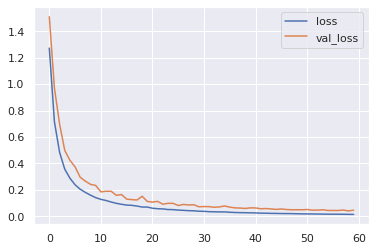

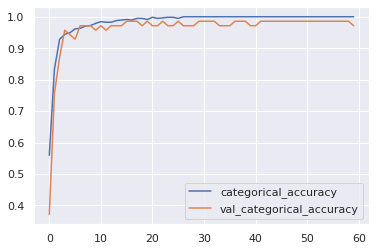

In [16]:
history_df = pd.DataFrame(history.history)
history_df[['loss', 'val_loss']].plot()
history_df[['categorical_accuracy', 'val_categorical_accuracy']].plot()

In [17]:
validation.reset()
print("True:", validation.labels)
print("Predictions: ", model.predict(validation).argmax(axis=1))

True: [4, 4, 6, 5, 2, 0, 1, 2, 2, 0, 2, 6, 4, 2, 0, 1, 6, 3, 5, 3, 0, 2, 5, 3, 4, 1, 4, 3, 6, 0, 4, 0, 0, 1, 4, 5, 5, 5, 6, 6, 1, 6, 5, 0, 5, 6, 2, 3, 1, 0, 3, 1, 2, 3, 4, 5, 3, 4, 5, 6, 2, 1, 1, 2, 1, 3, 6, 3, 0, 4]
Predictions:  [4 4 6 5 2 0 1 2 2 0 5 6 4 2 0 1 6 3 5 5 0 2 5 3 4 1 4 3 6 0 4 0 0 1 4 5 5
 5 6 6 1 6 5 0 5 6 2 3 1 0 3 1 2 3 4 5 3 4 5 6 2 1 1 2 1 3 6 3 0 4]


              precision    recall  f1-score   support

           0       1.00      1.00      1.00        10
           1       1.00      1.00      1.00        10
           2       1.00      0.90      0.95        10
           3       1.00      0.90      0.95        10
           4       1.00      1.00      1.00        10
           5       0.83      1.00      0.91        10
           6       1.00      1.00      1.00        10

    accuracy                           0.97        70
   macro avg       0.98      0.97      0.97        70
weighted avg       0.98      0.97      0.97        70



Text(30.499999999999993, 0.5, 'True')

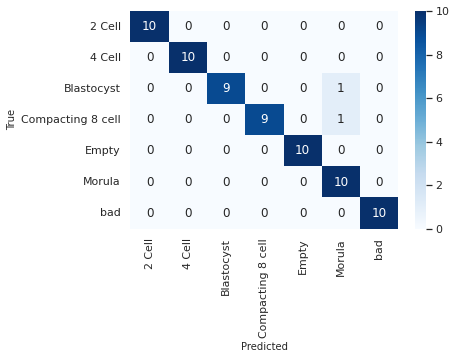

In [18]:
validation.reset()
y_pred = model.predict(validation).argmax(axis=1)
print(classification_report(validation.labels, y_pred))
labels = list(training.class_indices.keys())
s = sns.heatmap(confusion_matrix(validation.labels, y_pred), annot=True, cmap='Blues',
            xticklabels=labels, yticklabels=labels)
s.set_xlabel('Predicted', fontsize=10)
s.set_ylabel('True', fontsize=10)

In [19]:
model.save(f"models/{len(code2class)}_class.h5")